In [1]:
# Upload Excel File
from google.colab import files
uploaded = files.upload()

Saving SupplyChainEmissionFactorsforUSIndustriesCommodities (1) (2).xlsx to SupplyChainEmissionFactorsforUSIndustriesCommodities (1) (2).xlsx


In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [3]:
# Load and Combine Sheets
file_path = list(uploaded.keys())[0]
xls = pd.ExcelFile(file_path)
sheets = [f"{year}_Detail_Commodity" for year in range(2010, 2017)]
df = pd.concat([xls.parse(sheet).assign(Year=int(sheet.split("_")[0])) for sheet in sheets], ignore_index=True)

In [4]:
# Clean and Prepare Data
df.drop(columns=["Unnamed: 7", "Commodity Code"], errors='ignore', inplace=True)
df.dropna(subset=["Supply Chain Emission Factors with Margins"], inplace=True)

cat_cols = ["Commodity Name", "Substance", "Unit"]
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

df.dropna(inplace=True)

In [5]:
# Feature and Target Setup
target_col = "Supply Chain Emission Factors with Margins"
X = df.drop(columns=[target_col])
y = df[target_col]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [6]:
# Train Models
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2 Score": r2_score(y_test, y_pred)
    }

In [7]:
# Hyperparameter Tuning - GridSearchCV
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20],
    'min_samples_split': [2, 4]
}
grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
y_pred_tuned = best_rf.predict(X_test)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [8]:
# Evaluation
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

In [9]:
# Save Model and Predictions
joblib.dump(best_rf, "best_random_forest_model.pkl")
joblib.dump(scaler, "scaler.pkl")
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_tuned}).to_csv("rf_predictions.csv", index=False)

In [10]:
# Print Results
print("\nModel Performance (Before Tuning):")
for model_name, metrics in results.items():
    print(f"{model_name} => RMSE: {metrics['RMSE']:.4f}, R² Score: {metrics['R2 Score']:.4f}")

print("\nFinal Random Forest After Tuning:")
print(f"Best Params: {grid.best_params_}")
print(f"Final RMSE: {rmse_tuned:.4f}, Final R² Score: {r2_tuned:.4f}")


Model Performance (Before Tuning):
Random Forest => RMSE: 0.0066, R² Score: 0.9995
Linear Regression => RMSE: 0.0003, R² Score: 1.0000
Gradient Boosting => RMSE: 0.0077, R² Score: 0.9993

Final Random Forest After Tuning:
Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Final RMSE: 0.0057, Final R² Score: 0.9996


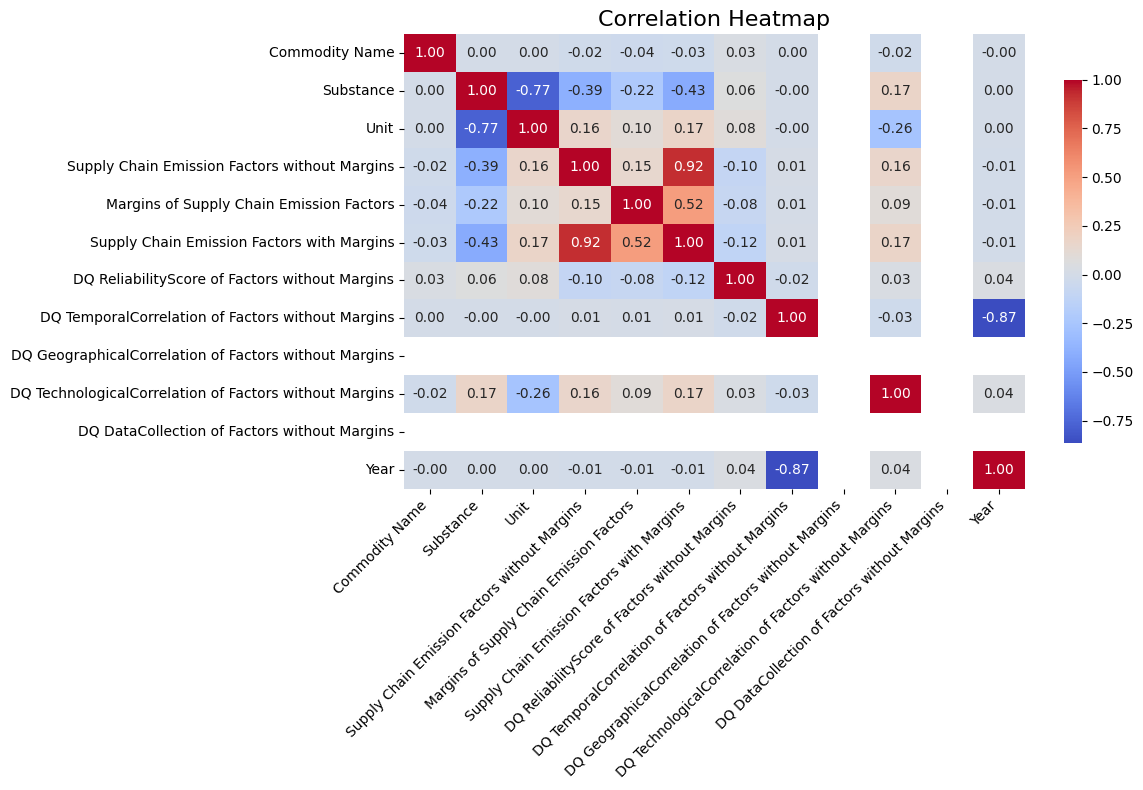

In [11]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'shrink': 0.8})
plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

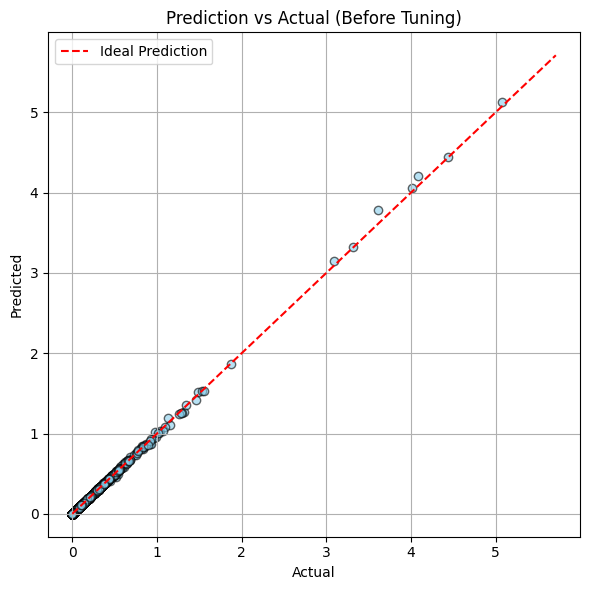

In [12]:
# Actual vs Predicted (Before Tuning)
default_rf = RandomForestRegressor(random_state=42)
default_rf.fit(X_train, y_train)
y_pred_default = default_rf.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_default, alpha=0.6, color='skyblue', edgecolor='black')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal Prediction')
plt.title("Prediction vs Actual (Before Tuning)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

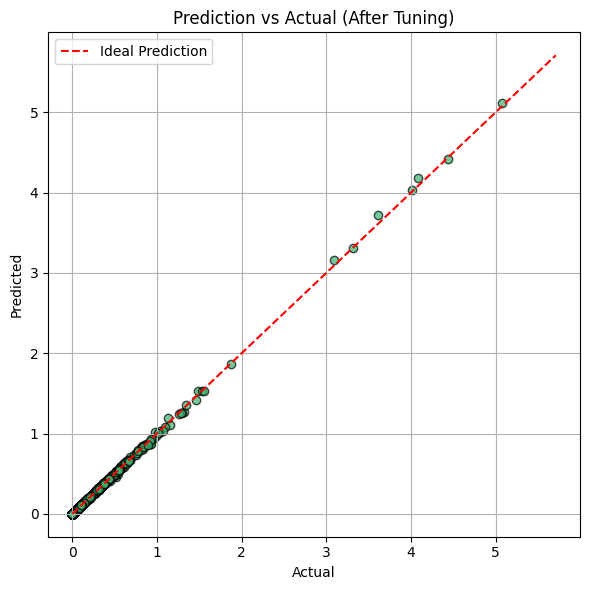

In [13]:
# Actual vs Predicted (After Tuning)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_tuned, alpha=0.7, color='mediumseagreen', edgecolor='black')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal Prediction')
plt.title("Prediction vs Actual (After Tuning)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()